In [1]:
import os
from torchvision import datasets
import torchvision
import torch
from torchvision.transforms import transforms
import torchvision.models as models
import numpy as np
from PIL import ImageFile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.ion()

In [2]:
batch_size = 64
num_workers = 0

# Multiple composition of images like resizing, normalizing etc
transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Collecting the train and test dataset
train_set = '/content/drive/MyDrive/Fire_dataset/fire_dataset/train'
valid_set = '/content/drive/MyDrive/Fire_dataset/fire_dataset/test'

# Resizing and normalizing the train and test dataset using transform function
train_data = datasets.ImageFolder(train_set, transform=transform)
valid_data = datasets.ImageFolder(valid_set, transform=transform)

# Prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

loaders = {
    'train': train_loader,
    'valid': valid_loader
}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Categorizing the dataset 
class_names = ['Fire', 'No_fire']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

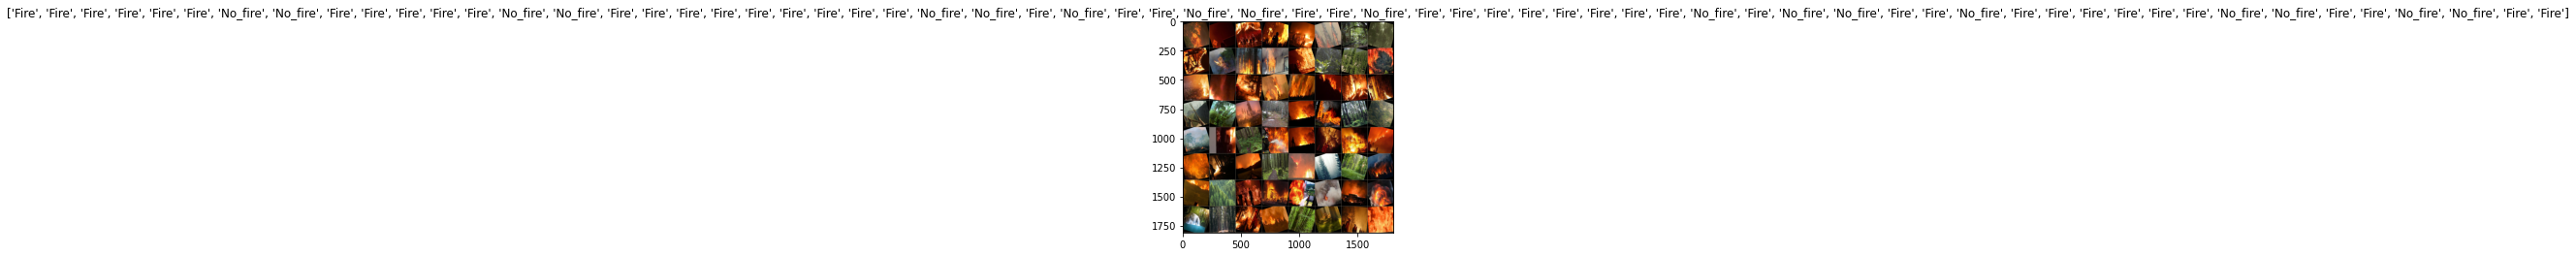

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
# Modelling with resnet50
model = models.resnet50(pretrained=True)

use_cuda = torch.cuda.is_available()

if use_cuda:
    model = model.cuda()
    
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
for param in model.parameters():
    param.requires_grad = False
    
# Applying sequential model over resnet50
model.fc = torch.nn.Sequential(torch.nn.Linear(2048,128),
                                      torch.nn.ReLU(),
                                       torch.nn.Linear(128,3),
                                       torch.nn.Softmax()
                                      )

for param in model.fc.parameters():
    param.requires_grad = True
    
if use_cuda:
    model_transfer = model.cuda()
    
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# Loss function
criterion = torch.nn.CrossEntropyLoss()

# To optimize the model
optimizer = torch.optim.Adam(model_transfer.fc.parameters(), lr=0.0005)


In [14]:
n_epochs = 100

train_accuracy_list = []
train_loss_list = []
valid_accuracy_list = []
valid_loss_list = []

def train(n_epochs, loader, model, optimizer, criterion, use_cuda, save_path):


  """Implementing a function to obtain training accuracy, training loss,
   validation accuracy and validation loss."""

    # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf
       
  for epoch in range(1, (n_epochs+1)):

        # initialize variables to monitor training loss, training accuracy, validation accuracy and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        
        ###################
        # train the model #
        ###################

        model.train()
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # clear out the gradients of all Variables from the last step
            optimizer.zero_grad()

            ## find the loss and update the model parameters accordingly
            output = model(data)
            _, preds = torch.max(output, 1)
            loss = criterion(output, target)

            # Derivative of the loss with respect to the parameter
            loss.backward()

           # optimizer to take a step based on the gradients of the parameters
            optimizer.step()
            
            train_acc = train_acc + torch.sum(preds == target.data)

            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            ######################    
            # validate the model #
            ######################
            model.eval()

        for batch_idx, (data, target) in enumerate(loaders['valid']):

            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## update the average validation loss and validation accuracy
            output = model(data)
            _, preds = torch.max(output, 1)
            loss = criterion(output, target)
            
            valid_acc = valid_acc + torch.sum(preds == target.data)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        # Obtaining the training loss, validation loss, training accuracy and validation accuracy   
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        train_acc = train_acc/len(loaders['train'].dataset)
        valid_acc = valid_acc/len(loaders['valid'].dataset)
        
        #Appending the values in the list 
        train_accuracy_list.append(train_acc)
        train_loss_list.append(train_loss)
        valid_accuracy_list.append(valid_acc)
        valid_loss_list.append(valid_loss)
        
        # print training/validation statistics
        print('Epoch: {} \tTraining Acc: {:6f} \tTraining Loss: {:6f} \tValidation Acc: {:6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_acc,
            train_loss,
            valid_acc,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss  
            
  return model

In [15]:
# Train the model
model = train(n_epochs, loaders, model, optimizer, criterion, use_cuda, '/content/model_final.pth')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 	Training Acc: 0.698091 	Training Loss: 0.001012 	Validation Acc: 1.000000 	Validation Loss: 0.002643
Validation loss decreased (inf --> 0.002643).  Saving model ...
Epoch: 2 	Training Acc: 0.924821 	Training Loss: 0.000799 	Validation Acc: 1.000000 	Validation Loss: 0.002409
Validation loss decreased (0.002643 --> 0.002409).  Saving model ...
Epoch: 3 	Training Acc: 0.959427 	Training Loss: 0.000730 	Validation Acc: 0.995798 	Validation Loss: 0.002365
Validation loss decreased (0.002409 --> 0.002365).  Saving model ...
Epoch: 4 	Training Acc: 0.953461 	Training Loss: 0.000731 	Validation Acc: 0.966387 	Validation Loss: 0.002523
Epoch: 5 	Training Acc: 0.953461 	Training Loss: 0.000722 	Validation Acc: 0.995798 	Validation Loss: 0.002379
Epoch: 6 	Training Acc: 0.966587 	Training Loss: 0.000709 	Validation Acc: 0.991597 	Validation Loss: 0.002365
Epoch: 7 	Training Acc: 0.958234 	Training Loss: 0.000708 	Validation Acc: 0.987395 	Validation Loss: 0.002376
Epoch: 8 	Training Ac

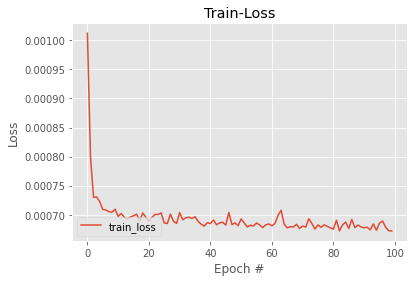

In [16]:
#  Plotting training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.title("Train-Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

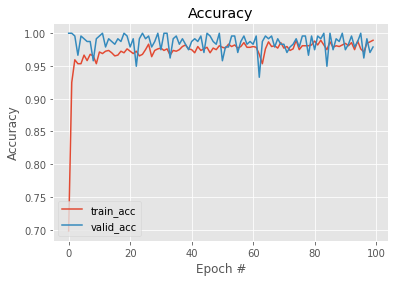

In [17]:
# Plotting the accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(train_accuracy_list, label="train_acc")
plt.plot(valid_accuracy_list, label="valid_acc")

plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [18]:
# Saving the values 
torch.save(model, '/content/model_fitted.pth')

In [19]:
print("[INFO] loading model...")
model = torch.load('/content/model_fitted.pth')

[INFO] loading model...


In [20]:
from PIL import Image

class_names = class_names = ['Fire', 'No_fire']

def predict(image):
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    image = image.cuda()

    pred = model(image)
    idx = torch.argmax(pred)
    prob = pred[0][idx].item()*100
    
    return class_names[idx], prob

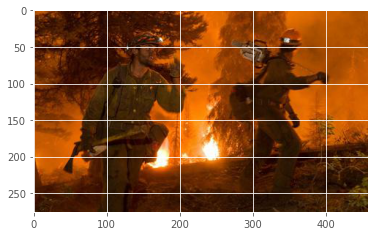

Fire 99.88769888877869


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [22]:
img = Image.open('/content/drive/MyDrive/Fire_dataset/fire_dataset/test/fire/fire.101.jpg')
plt.imshow(img)
plt.show()

prediction, prob = predict(img)
print(prediction, prob)

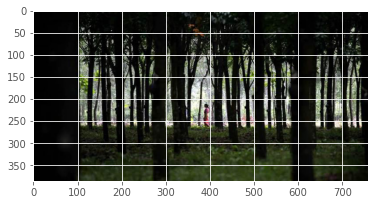

No_fire 99.99743700027466


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [32]:
img = Image.open('/content/drive/MyDrive/Fire_dataset/fire_dataset/train/nofire/nofire.110.jpg')
plt.imshow(img)
plt.show()

prediction, prob = predict(img)
print(prediction, prob)